In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
number_of_runs = 10

mid_price_files = []

for i in range(number_of_runs):
    file = f"/Users/admin/Workspace/apxr/output/apxr_mid_prices{i+1}.csv"
    mid_price_files.append(file)

In [90]:
from numpy import genfromtxt

mid_price_data = genfromtxt(mid_price_files[0], delimiter=',')

for f in mid_price_files[1:]:
    mid_price_data += genfromtxt(f, delimiter=',')

mid_price_data /= len(mid_price_files)

mid_prices = pd.DataFrame(mid_price_data, columns=['MidPrice'])
mid_prices.head(10)

,MidPrice
0,100.017
1,100.016
2,100.016
3,100.018
4,100.018
5,100.018
6,100.020
7,100.020
8,100.020
9,100.020


In [91]:
mid_prices["Returns"] = mid_prices["MidPrice"].pct_change(1)
mid_prices.head(10)

,MidPrice,Returns
0,100.017,NaN
1,100.016,-0.00001
2,100.016,0.00000
3,100.018,0.00002
4,100.018,0.00000
5,100.018,0.00000
6,100.020,0.00002
7,100.020,0.00000
8,100.020,0.00000
9,100.020,0.00000


In [92]:
trade_price_files = []

for i in range(number_of_runs):
    file = f"/Users/admin/Workspace/apxr/output/apxr_trades{i+1}.csv"
    trade_price_files.append(file)

In [93]:
trade_price_data = []

for filename in trade_price_files:
    tr = pd.read_csv(filename, header=None)
    tr.columns = columns=["TradePrice"]
    trade_price_data.append(tr)

trade_price_data_avg = pd.concat(trade_price_data, axis=1).mean(axis=1)
trade_prices = pd.DataFrame(trade_price_data_avg, columns=['TradePrice'])
trade_prices.head(10)

,TradePrice
0,100.018
1,100.013
2,100.015
3,100.013
4,100.011
5,100.012
6,100.013
7,100.013
8,100.015
9,100.014


In [94]:
trade_prices["Returns"] = trade_prices["TradePrice"].pct_change(1)
trade_prices.head(10)

,TradePrice,Returns
0,100.018,NaN
1,100.013,-0.00005
2,100.015,0.00002
3,100.013,-0.00002
4,100.011,-0.00002
5,100.012,0.00001
6,100.013,0.00001
7,100.013,0.00000
8,100.015,0.00002
9,100.014,-0.00001


## Fat tailed distribution of returns

In [95]:
time = []
kurt = []

for lag in range(2500):
    lagged_returns = mid_prices["MidPrice"].pct_change(lag)
    kurtosis = lagged_returns.kurt()
    kurt.append(kurtosis)
    time.append(lag)

# Remove first observation since it is zero and Nan
time = time[1:]
kurt = kurt[1:]

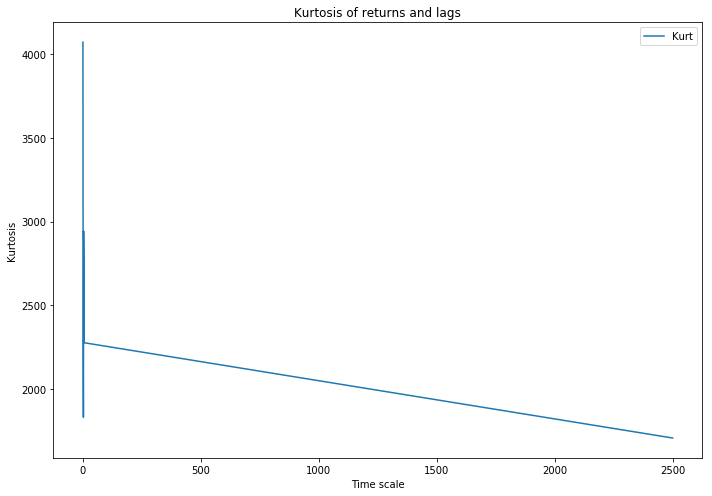

In [96]:
plt.figure(figsize=(10, 7))

plt.plot(time, kurt, label="Kurt")
plt.legend()
plt.xlabel("Time scale")
plt.ylabel("Kurtosis")
plt.title("Kurtosis of returns and lags")
plt.tight_layout()

## Volatility clustering

In [ ]:
import sys
!{sys.executable} -m pip install hurst

In [ ]:
# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
from hurst import compute_Hc, random_walk
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(mid_prices["MidPrice"], kind='random_walk', simplified=True)

# Plot

f, ax = plt.subplots(figsize=(10, 7))
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [ ]:
H, c, data = compute_Hc(mid_prices["MidPrice"], kind='price', simplified=True)

In [ ]:
coeff_list = []

for lag in range(1, 200):
    H, c, data = compute_Hc(mid_prices["MidPrice"].pct_change(lag).dropna().abs(), 
                            kind='random_walk', simplified=True)
    coeff_list.append(H)

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(199), coeff_list)
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('% of simulations with significant clustering')
ax.grid(True)
plt.title("Volatility Clustering")
plt.show()

## Autocorrelation of returns

In [ ]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    return result[int(len(result)/2):]

In [ ]:
lag = 1

# First lag of returns of mid prices
returns_first_lag = mid_prices["Returns"]
returns_first_lag_ac = autocorrelation(returns_first_lag[2:])

# First lag of returns of transactions
tr_first_lag = tr["Returns"]
tr_first_lag_ac = autocorrelation(tr_first_lag[2:])

In [ ]:
summary = pd.DataFrame(returns_first_lag_ac, columns=["MidPrices"])
summary.describe()

In [ ]:
summary = pd.DataFrame(tr_first_lag_ac, columns=["MidPrices"])
summary.describe()

## Long memory in order flow

In [ ]:
# first order lag autocorrelation of the order-sign
lag = 1
coeff = np.log(np.mean(autocorrelation(tr["Direction"])))
print("Coeff is:", coeff)

In [ ]:
# hurst exponent

H, c, data = compute_Hc(tr["Direction"].dropna().abs(), 
                            kind='random_walk', simplified=True)
print("Hurst coeff for order-sign is:", H)

## Concave Price impact

In [ ]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(tr["Volume"].values.reshape(-1, 1), tr["Price"])

In [ ]:
clf.coef_

In [ ]:
tr["Volume"].describe()

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(1, 1500), clf.coef_ * np.arange(1, 1500) + clf.intercept_)
ax.set_xlabel('Volume')
ax.set_ylabel('Price Impact')
ax.set_xlim((0, 1400))
ax.grid(True)
plt.title("Concave Price Impact")
plt.show()

In [ ]:
mid_prices.head(10)

## Extreme Price Events

In [ ]:
mid_prices.iloc[0]["MidPrice"]

In [ ]:
def is_extreme(position, df):
    """Returns true for a position if it consistently takes
    up/down position for 10 times before switching to the
    opposite and the net change is at least 0.8% of initial
    price"""
    initial_price = df.iloc[0]["MidPrice"]
    prices = df["MidPrice"].values
    curr_price = prices[position]
    increasing = True
    for i in range(position + 1, position + 10):
        if curr_price >= prices[i]:
            increasing = False
            break
    if increasing:
        delta = abs(prices[position] - prices[position + 10])
        if delta > initial_price * 0.08:
            return True
    decreaing = True
    for i in range(position + 1, position + 10):
        if curr_price <= prices[i]:
            decreaing = False
            break
    if decreaing:
        delta = abs(prices[position] - prices[position + 10])
        if delta > initial_price * 0.08:
            return True
    return False

In [ ]:
# checking for working
for i in range(20 - 10):
    print(is_extreme(i, pd.DataFrame(np.arange(0, 20), columns=["MidPrice"])))

In [ ]:
extreme_events = []
for i in range(len(mid_prices) - 10):
    if is_extreme(i, mid_prices):
        # save position
        extreme_events.append(i)

In [ ]:
extreme_events

For the current dataset, it appears there are no extreme events

In [ ]:
# assuming there is one event, just to plot
extreme_events = [1]
f, ax = plt.subplots(figsize=(7, 4))
plt.plot(np.arange(1), extreme_events)
ax.set_xlabel('Event Duration')
ax.set_ylabel('Relative number of events')
ax.set_xlim((0, 1400))
ax.grid(True)
plt.title("Concave Price Impact")
plt.tight_layout()
